# Getting Started



## Installation

> ### ⚠️ Important Note for macOS Users
>
> **wristpy** depends on `libomp`, a system-level dependency that is not always installed by default on macOS. Install it via:
>
> ```bash
> brew install libomp
> ```



Install the `wristpy` package from PyPI via:

```sh
pip install wristpy
```



## Introduction 
The main processing pipeline of the wristpy module can be described as follows:

- **Data loading**: sensor data is loaded using [`actfast`](https://github.com/childmindresearch/actfast), and a `WatchData` object is created to store all sensor data.
- **Data calibration**: A post-manufacturer calibration step can be applied, to ensure that the acceleration sensor is measuring 1*g* force during periods of no motion. There are three possible options: `None`, `gradient`, `ggir`.
- ***Data imputation*** In the special case when dealing with the Actigraph `idle_sleep_mode == enabled`, the gaps in acceleration are filled in after calibration, to avoid biasing the calibration phase.
- **Metrics Calculation**: Calculates various activity metrics on the calibrated data, namely ENMO (Euclidean norm, minus one), MAD (mean amplitude deviation) <sup>1</sup>, Actigraph activity counts<sup>2</sup>, MIMS (monitor-independent movement summary) unit <sup>3</sup>, and angle-Z (angle of acceleration relative to the *x-y* axis).
- **Non-wear detection**: We find periods of non-wear based on the acceleration data. Specifically, the standard deviation of the acceleration values in a given time window, along each axis, is used as a threshold to decide `wear` or `not wear`. Additionally, we can use the temperature sensor, when avaialable, to augment the acceleration data. This is used in the CTA (combined temperature and acceleration) algorithm <sup>4</sup>, and in the `skdh` DETACH algorithm <sup>5</sup>. Furthermore, ensemble classification of non-wear periods is possible by providing a list (of any length) of non-wear algorithm options.
- **Sleep Detection**: Using the HDCZ<sup>6</sup> and HSPT<sup>7</sup> algorithms to analyze changes in arm angle we are able to find periods of sleep. We find the sleep onset-wakeup times for all sleep windows detected. Any sleep periods that overlap with detected non-wear times are removed, and any remaining sleep periods shorter than 15 minutes (default value) are removed. Additionally, the SIB (sustained inactivity bouts) and the SPT (sleep period time) windows are provided as part of the output to aid in sleep metric post-processing.
- **Physical activity levels**: Using the chosen physical activity metric (aggregated into time bins, 5 second default) we compute activity levels into the following categories: [`inactive`, `light`, `moderate`, `vigorous`]. The threshold values can be defined by the user, while the default values are chosen based on the specific activity metric and the values found in the literature  <sup>8-10</sup>.
- **Data output**: The output results can be saved in `.csv` or `.parquet` data formats, with the run-time configuration parameters saved in a `.json` dictionary.



## Command Line Tutorial 

Run a single file:

```bash
   wristpy /input/file/path.gt3x -o /save/path/file_name.csv -c gradient
```
Run an entire directory:
```bash
   wristpy /path/to/files/input_dir -o /path/to/files/output_dir -c gradient -O .csv
```

You can also choose one or more activity metric:
```bash
   wristpy /input/file/path.gt3x -o /save/path/file_name.csv -c gradient -a enmo -a mad
```
Specify the epoch length in seconds (will default to 5 seconds):
```bash
   wristpy /input/file/path.gt3x -o /save/path/file_name.csv -c gradient -a enmo -a mad -e 3
```

To specificy your own activity thresholds  enter them in the same order as the corresponding metric:
```bash
   wristpy /input/file/path.gt3x -o /save/path/file_name.csv -c gradient -a enmo -a mad -t "1 2 3" -t "1.5 2.5 3.5"
```

See all available command-line arguments:
```bash
   wristpy --help
```

## Python Tutorial 

Wristpy is a Python library designed for processing and analyzing wrist-worn accelerometer data.
This tutorial will guide you through the basic steps of using `wristpy` to analyze your accelerometer data using python. Specifically,
we will cover the following topics through a few examples:
   - running the default processor, analyzing the output data, and visualizing the results.
   - loading data and plotting the raw signals.
   - how to calibrate the data, computing ENMO and angle-z from the calibrated data and then plotting those metrics.
   - how to obtain non-wear windows and visualize them.
   - how to obtain sleep windows and visualize them.





### Example 1: Running the default processor

#### Running files and directories


The `orchestrator` module of wristpy contains the default processor that will run the entire wristpy processing pipeline. This can be called as simply as:

In [19]:
import pathlib

from wristpy.core import orchestrator

input_directory = pathlib.Path('tutorial_data')
output_directory = pathlib.Path.cwd().parent / 'build'

results = orchestrator.run(
   input = input_directory / 'three_nights.bin',  
   output = output_directory / 'three_nights_single_file.csv', 
)

This runs the processing pipeline with all the default arguments, creates an output `.csv` file, a `.json` file with the pipeline configuration parameters, and will create a `results` object that contains the various output metrics (namely; the specified physical activity metric, angle-z, physical activity classification values, non-wear status, and sleep status).


The orchestrator can also process entire directories. The call to the orchestrator remains largely the same but now output is expected to be a directory and the desired filetype for the saved files can be specified through the output_filetype arguement(default value is ".csv"):

In [20]:
from wristpy.core import orchestrator

results = orchestrator.run(
    input = input_directory,
    output = output_directory,
    output_filetype = ".csv"
)

2025-09-17 09:49:59,331 - wristpy - ERROR - orchestrator.py:248 - _run_directory - Did not run file: tutorial_data/three_nights.bin, Error: Error reading file: No such file or directory (os error 2). File type is unsupported.


If users would prefer to process specific files instead of entire directories we recommend looping through a list of file names. The following code snipet will save results objects into a dictionary, and the output files into the desired directory:

In [21]:

file_names = [pathlib.Path("three_nights.bin")] # Add more file names to list as needed
results_dict = {}

for file in file_names:
    input_path = input_directory / file
    output_path = output_directory / file.with_suffix('.csv')
    result = orchestrator.run(
        input = input_path,
        output = output_path)
    results_dict[file.stem] = result

#### Physical Activity Metrics & Results

Wristpy is capable of calculating the following physical activity metrics from actigraphy data:
1. [Euclidean Norm Minus-One (ENMO)](https://childmindresearch.github.io/wristpy/getting_started.html#enmo-euclidean-norm-minus-one)
2. [Activity Counts (ag_count)](https://childmindresearch.github.io/wristpy/getting_started.html#actigraph-activity-counts-ag-counts)
3. [Mean Amplitude Deviation (MAD)](https://childmindresearch.github.io/wristpy/getting_started.html#mad-mean-amplitude-deviation)
4. [Monitor Independent Movement Summary Units (MIMS)](https://childmindresearch.github.io/wristpy/getting_started.html#mims-monitor-independent-summary-units)

The default metric is ENMO, but you can pass any combination of supported metrics as a list to the orchestrator:

In [22]:

results = orchestrator.run(
   input = input_directory / 'three_nights.bin',
   output = output_directory / 'three_nights_multiple_metrics.csv',
   activity_metric = ['enmo', 'mad',]
)

The resulting [OrchestratorResults](https://childmindresearch.github.io/wristpy/api/wristpy.io.writers.writers.html#wristpy.io.writers.writers.OrchestratorResults) object will contain the outputs for each metric in the order they were provided. The same applies to the physical activity levels associated with each metric.

In [23]:
enmo = results.physical_activity_metric[0] # type: ignore
mad = results.physical_activity_metric[1] # type: ignore

enmo_levels = results.physical_activity_levels[0] # type: ignore
mad_levels = results.physical_activity_levels[1] # type: ignore

We can visualize some of the outputs within the `results` object, directly, with the following scripts:

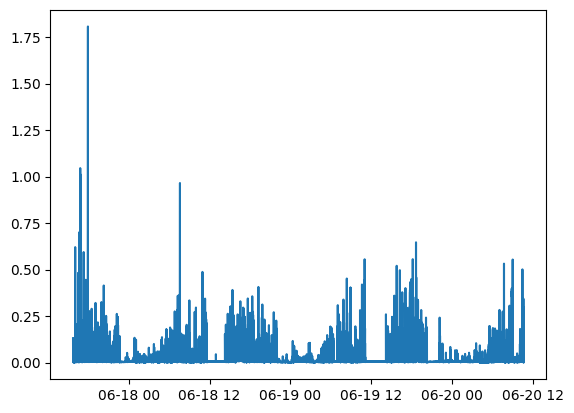

In [24]:
#Plot the default physical activity metrics (ENMO) across the entire data set:

from matplotlib import pyplot as plt

plt.plot(results.physical_activity_metric[0].time, results.physical_activity_metric[0].measurements) # type: ignore

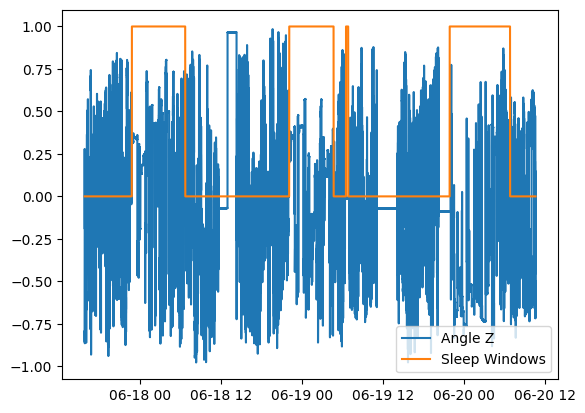

In [25]:
# Plot the sleep windows with normalized angle-z data:

from matplotlib import pyplot as plt

plt.plot(results.anglez.time, results.anglez.measurements/90) # type: ignore
plt.plot(results.sleep_status.time, results.sleep_status.measurements) # type: ignore
plt.legend(['Angle Z', 'Sleep Windows'])
plt.show()

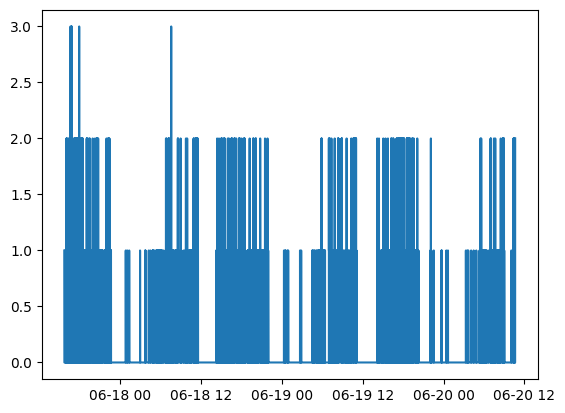

In [26]:
#We can also view and process these outputs from the saved `.csv` output file:

import matplotlib.pyplot as plt
import polars as pl

output_results = pl.read_csv(output_directory/ 'three_nights.csv', try_parse_dates=True)

activity_mapping = {
    "inactive": 0,
    "light": 1,
    "moderate": 2,
    "vigorous": 3
}

phys_activity = output_results['enmo physical activity levels'].replace(activity_mapping).cast(int)

plt.plot(output_results['time'], phys_activity)

In [27]:
# It is also possible to do some analysis on these output variables, for example, if we want to find the percent of time spent inactive, or in light, moderate, or vigorous physical activity:

inactivity_count = sum(phys_activity == 0)
light_activity_count = sum(phys_activity == 1)
moderate_activity_count = sum(phys_activity == 2)
vigorous_activity_count = sum(phys_activity == 3)
total_activity_count = len(output_results['enmo physical activity levels'])

print(f'Light activity percent: {light_activity_count*100/total_activity_count}')
print(f'Moderate activity percent: {moderate_activity_count*100/total_activity_count}')
print(f'Vigorous activity percent: {vigorous_activity_count*100/total_activity_count}')
print(f'Inactivity percent: {inactivity_count*100/total_activity_count}')

Light activity percent: 12.394840157038699
Moderate activity percent: 1.1030099083940923
Vigorous activity percent: 0.031158471988533682
Inactivity percent: 86.47099146257868


> #### Configuring a custom pipeline
>
> A custom processing pipeline can be easily created by modifying the input arguments to the `orchestrator.run` call.
>> Complete documentation on these parameters can be found [here](https://childmindresearch.github.io/wristpy/wristpy/core/orchestrator.html#run).
>> Example:


In [28]:
results = orchestrator.run(input = input_directory / "three_nights.bin", output = output_directory / "custom_pipeline.csv", output_filetype = ".parquet", calibrator="gradient", activity_metric=["ag_count"], nonwear_algorithm=["detach"], epoch_length=10, thresholds=[(0.05, 0.1, 0.3)])

### Example 2: Loading data and plotting the raw signals


In this example we will go over the built-in functions to directly read the raw accelerometer and light data, and how to quickly visualize this information.

The built-in `readers` module can be used to load all the sensor and metadata from one of the support wristwatches (`.gt3x` or `.bin`), the reader will automatically select the appropriate loading methodology.

In [29]:
from wristpy.io.readers import readers

watch_data = readers.read_watch_data(input_directory / "three_nights.bin")

We can then visualize the raw accelerometer and light sensor values very easily as follows:

Plot the raw acceleration along the *x*-axis:

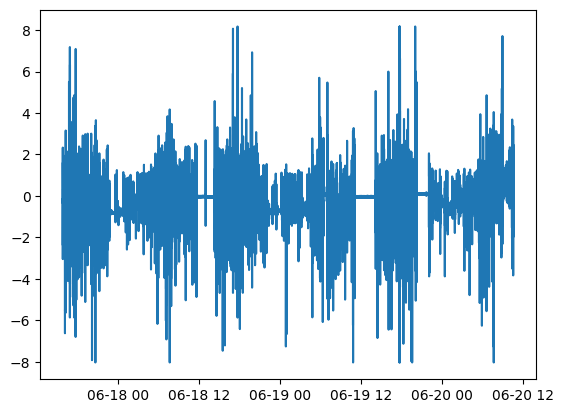

In [30]:
plt.plot(watch_data.acceleration.time, watch_data.acceleration.measurements[:,0])

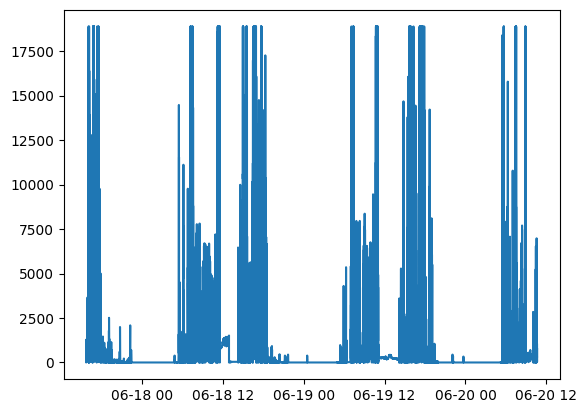

In [31]:
#Plot the light data:

plt.plot(watch_data.lux.time, watch_data.lux.measurements) # type: ignore

### Example 3:  Plot the epoch-level measurements

In this example we will expand on the skills learned in `Example 2`: we will load the sensor data, calibrate, and then calculate the ENMO and angle-z data in 5s windows (epoch-level data).

In [32]:
from wristpy.core import computations
from wristpy.io.readers import readers
from wristpy.processing import calibration, metrics

watch_data = readers.read_watch_data(input_directory / "three_nights.bin")

#Calibration phase
calibrator_object = calibration.ConstrainedMinimizationCalibration()
calibrated_data = calibrator_object.run_calibration(watch_data.acceleration)

#Compute the desired metrics
enmo = metrics.euclidean_norm_minus_one(calibrated_data)
anglez = metrics.angle_relative_to_horizontal(calibrated_data)

#Obtain the epoch-level data, default is 5s windows
enmo_epoch1 = computations.moving_mean(enmo)
anglez_epoch1 = computations.moving_mean(anglez)

We can then visualize the `epoch1` measurements as:

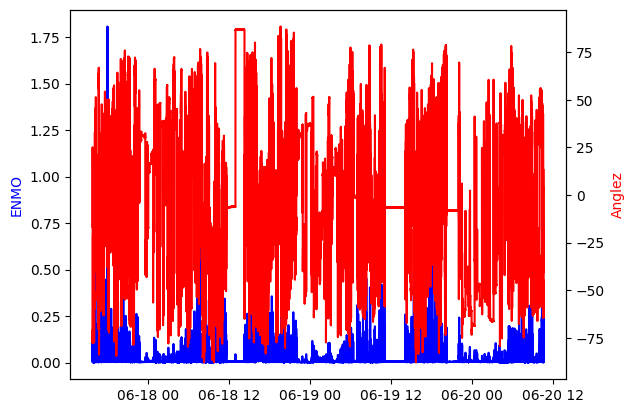

In [33]:

fig, ax1 = plt.subplots()


ax1.plot(enmo_epoch1.time, enmo_epoch1.measurements, color='blue')
ax1.set_ylabel('ENMO', color='blue')

ax2 = ax1.twinx()
ax2.plot(anglez_epoch1.time, anglez_epoch1.measurements, color='red')
ax2.set_ylabel('Anglez', color='red')

plt.show()

### Example 4: Visualize the detected non-wear times

In this example we will build on `Example 3` by also solving for the non-wear periods, as follows:

In [34]:
from wristpy.io.readers import readers
from wristpy.processing import calibration, metrics

watch_data = readers.read_watch_data(input_directory / "three_nights.bin")
calibrator_object = calibration.ConstrainedMinimizationCalibration()
calibrated_data = calibrator_object.run_calibration(watch_data.acceleration)

#Find non-wear periods, using the DETACH algorithm
non_wear_array = metrics.detect_nonwear(calibrated_data)

We can then visualize the non-wear periods, in comparison to movement (ENMO at the epoch-level):

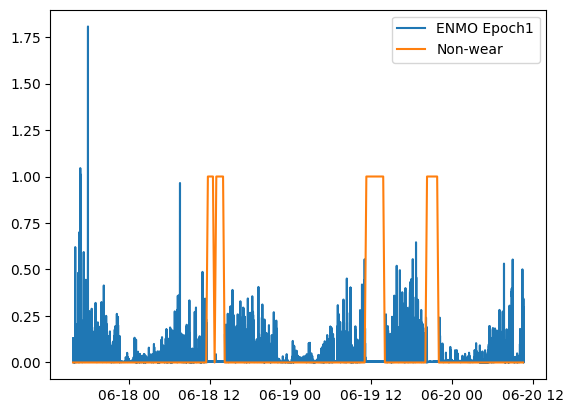

In [35]:
from wristpy.core import computations

enmo = metrics.euclidean_norm_minus_one(calibrated_data)
enmo_epoch1 = computations.moving_mean(enmo)


plt.plot(enmo_epoch1.time, enmo_epoch1.measurements)
plt.plot(non_wear_array.time, non_wear_array.measurements)

plt.legend(['ENMO Epoch1', 'Non-wear'])

### Example 5: Compute and plot the sleep windows


We can visualize the sleep periods in comparison to other metrics; in this example, we compare the sleep windows to the angle-z data and the non-wear periods. In the default pipeline any sleep periods that overlap with non-wear periods are filtered out.
This plot shows the sleep periods visualized by a blue trace, non-wear periods are visualized with a green trace, and the angle-z data with the semi-transparent red trace. These are all accessible directly from the results object created with the custom pipeline:

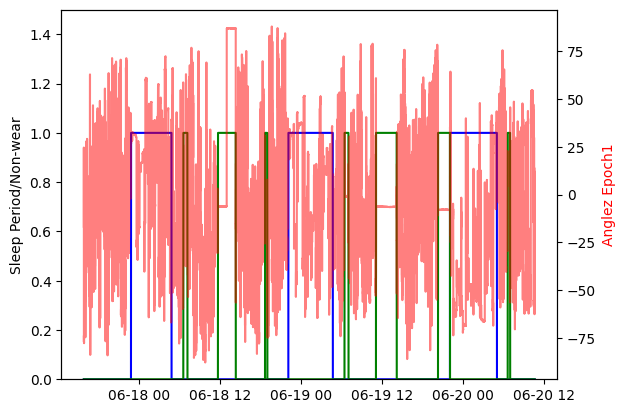

In [36]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

ax1.plot(results.sleep_status.time, results.sleep_status.measurements, color='blue', label='Sleep Periods')
plt.plot(results.nonwear_status.time, results.nonwear_status.measurements, color='green')
ax2 = ax1.twinx()
ax2.plot(results.anglez.time, results.anglez.measurements, color='red', alpha=0.5)
ax2.set_ylabel('Anglez Epoch1', color='red')

ax1.set_ylabel('Sleep Period/Non-wear')
ax1.set_ylim(0, 1.5)

plt.show()


## Docker Tutorial 

1. **Install Docker**: Ensure you have Docker installed on your system. [Get Docker](https://docs.docker.com/get-docker/)

2. **Pull the Docker image**:
   ```bash
   docker pull cmidair/wristpy:main
   ```

3. **Run the Docker image** with your data:
   ```bash
   docker run -it --rm \
     -v "/local/path/to/data:/data" \
     -v "/local/path/to/output:/output" \
     cmidair/wristpy:main
   ```
   Replace `/local/path/to/data` with the path to your input data directory and `/local/path/to/output` with where you want results saved.

   To run a single file, we simply need to modify the mounting structure for the docker call slightly:
    ```bash
    docker run -it --rm \
     -v "/local/path/to/data/file.bin:/data/file.bin" \
     -v "/local/path/to/output:/output" \
     cmidair/wristpy:main
   ```

4. **Customizing the Pipeline**:

The Docker image supports multiple input variables to customize processing. You can set these by simply chaining these inputs as you would for the CLI input:

  ```bash
  docker run -it --rm \
    -v "/local/path/to/data/file.bin:/data/file.bin" \
    -v "/local/path/to/output:/output" \
    cmidair/wristpy:main /data --output /output --epoch-length 5 --nonwear-algorithm ggir --nonwear-algorithm detach --thresholds 0.1 0.2 0.4
  ```



## Physical Activity Metrics Explained

### *ENMO— Euclidean Norm Minus One*  
ENMO quantifies movement intensity from calibrated 3-axis acceleration by taking the vector magnitude and subtracting 1 g (gravity). Values below zero are set to 0 (they mostly reflect noise or tiny calibration errors). 

**References:**  
- van Hees, V. T., Gorzelniak, L., Dean León, E. C., Eder, M., Pias, M., Taherian, S., Ekelund, U., Renström, F., Franks, P. W., Horsch, A., & Brage, S. (2013). Separating movement and gravity components in an acceleration signal and implications for the assessment of human daily physical activity. *PLoS ONE, 8*(4), e61691. https://doi.org/10.1371/journal.pone.0061691  
- Hildebrand, M., van Hees, V. T., Hansen, B. H., & Ekelund, U. (2014). Age group comparability of raw accelerometer output from wrist- and hip-worn monitors. *Medicine & Science in Sports & Exercise, 46*(9), 1816–1824. https://doi.org/10.1249/MSS.0000000000000289  


### *MAD — Mean Amplitude Deviation*
MAD summarizes how much the acceleration magnitude fluctuates within an epoch. Specifically it’s the mean of the absolute deviations from the epoch’s mean acceleration magnitude. It correlates well with energy expenditure and is orientation-independent.

**Reference:**  
- Vähä-Ypyä, H., Vasankari, T., Husu, P., Suni, J., & Sievänen, H. (2015). A universal, accurate intensity-based classification of different physical activities using raw data of accelerometer. *Clinical Physiology and Functional Imaging, 35*(1), 64–70. https://doi.org/10.1111/cpf.12127  


### *MIMS — Monitor-Independent Summary Units*
MIMS is a standardized, device-agnostic summary unit. The pipeline interpolates to a fixed frequency (100 Hz), extrapolates values outside device range, band-pass filters, integrates area-under-the-curve per axis over each epoch, then combines axes (sum or vector magnitude) with small-value truncation. It’s designed to be comparable across devices and studies. This metric is computationally intensive and will run significantly slower than the other algorithms.

**Reference:**  
- John, D., Tang, Q., Albinali, F., & Intille, S. (2019). An open-source monitor-independent movement summary for accelerometer data processing. *Journal for the Measurement of Physical Behaviour, 2*(4), 268–281. https://doi.org/10.1123/jmpb.2019-0011  


### *ActiGraph Activity Counts (ag_counts)*
This reproduces the open ActiGraph counts method: resample to 30 Hz, apply the published IIR band-pass filter, scale to device units, threshold, downsample to 10 Hz, and sum within each epoch. The three axes are finally combined  to yield epoch-level “counts.”

**Reference:**  
- Neishabouri, A., Wilson, K. E., Williams, D. K., Keadle, S. K., Sampson, J., John, D., & Staudenmayer, J. (2022). Quantification of acceleration as activity counts in ActiGraph wearable. *Scientific Reports, 12*(1), 11169. https://doi.org/10.1038/s41598-022-16003-x  




## A Special Note on Idle Sleep Mode. 

The `idle_sleep_mode` for Actigraph watches will lead to uneven sampling rates during periods of no motion (read about this [here](https://actigraphcorp.my.site.com/support/s/article/Idle-Sleep-Mode-Explained)). Consequently, this causes issues when implementing wristpy's non-wear and sleep detection. As of this moment, we fill in the missing acceleration data with the assumption that the watch is perfectly idle in the face-up position (Acceleration vector = [0, 0, -1]). The data is filled in at the same sampling rate as the raw acceleration data. In the special circumstance when acceleration samples are not evenly spaced, the data is resampled to the highest effective sampling rate to ensure linearly sampled data.